# Comparing FITC approximation to VFE approximation
This notebook examines why we prefer the Variational Free Energy (VFE) objective to the Fully Independent Training Conditional (FITC) approximation for our sparse approximations.


In [1]:
import gpflow
import tensorflow as tf
from gpflow.ci_utils import ci_niter  # to speed up automated testing of this notebook
import matplotlib.pyplot as plt
%matplotlib inline

from FITCvsVFE import (getTrainingTestData, printModelParameters, plotPredictions,
                       repeatMinimization, stretch, plotComparisonFigure)

import logging
#logging.disable(logging.WARN)  # do not clutter up the notebook with optimization warnings

First, we load the training data and plot it together with the exact GP solution (using the `GPR` model):

Exact model parameters:
  Likelihood variance = 0.074285
  Kernel variance     = 0.90049
  Kernel lengthscale  = 0.5825


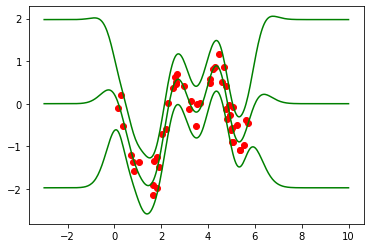

In [2]:
# Load the training data:
xtrain, ytrain, xtest, ytest = getTrainingTestData()

def getKernel():
    return gpflow.kernels.SquaredExponential()

# Run exact inference on training data:
exact_model = gpflow.models.GPR((xtrain, ytrain), kernel=getKernel())

@tf.function
def objective_closure():
    return - exact_model.log_marginal_likelihood()

opt = gpflow.optimizers.Scipy()
opt.minimize(objective_closure, exact_model.trainable_variables,
             method='L-BFGS-B',
             options=dict(maxiter=ci_niter(20000)), tol=1e-11)

print("Exact model parameters:")
printModelParameters(exact_model)

figA, ax = plt.subplots(1,1)
ax.plot(xtrain, ytrain, 'ro')
plotPredictions(ax, exact_model, color='g')

In [3]:
def initializeHyperparametersFromExactSolution(sparse_model):
    sparse_model.likelihood.variance.assign( exact_model.likelihood.variance )
    sparse_model.kernel.variance.assign( exact_model.kernel.variance )
    sparse_model.kernel.lengthscale.assign( exact_model.kernel.lengthscale )

We now construct two sparse model using the VFE (`SGPR` model) and FITC (`GPRFITC` model) optimization objectives, with the inducing points being initialized on top of the training inputs, and the model hyperparameters (kernel variance and lengthscales, and likelihood variance) being initialized to the values obtained in the optimization of the exact `GPR` model:

In [4]:
# Train VFE model initialized from the perfect solution.
VFEmodel = gpflow.models.SGPR((xtrain, ytrain), kernel=getKernel(),
                              inducing_variable=xtrain.copy())

initializeHyperparametersFromExactSolution(VFEmodel)

VFEcb = repeatMinimization(VFEmodel, xtest, ytest)  # optimize with several restarts
print("Sparse model parameters after VFE optimization:")
printModelParameters(VFEmodel)

Sparse model parameters after VFE optimization:
  Likelihood variance = 0.074286
  Kernel variance     = 0.90049
  Kernel lengthscale  = 0.5825


In [5]:
# Train FITC model initialized from the perfect solution.
FITCmodel = gpflow.models.GPRFITC((xtrain, ytrain), kernel=getKernel(),
                                  inducing_variable=xtrain.copy())

initializeHyperparametersFromExactSolution(FITCmodel)

FITCcb = repeatMinimization(FITCmodel, xtest, ytest)  # optimize with several restarts
print("Sparse model parameters after FITC optimization:")
printModelParameters(FITCmodel)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f4b60242390>, <gast.gast.Assign object at 0x7f4b6c02acd0>, <gast.gast.Return object at 0x7f4b6019dad0>]


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f4b60242390>, <gast.gast.Assign object at 0x7f4b6c02acd0>, <gast.gast.Return object at 0x7f4b6019dad0>]


Sparse model parameters after FITC optimization:
  Likelihood variance = 0.019116
  Kernel variance     = 1.3293
  Kernel lengthscale  = 0.61724


Plotting a comparison of the two algorithms, we see that VFE stays at the optimum of exact GPR, whereas the FITC approximation eventually ends up with several inducing points on top of each other, and a worse fit:

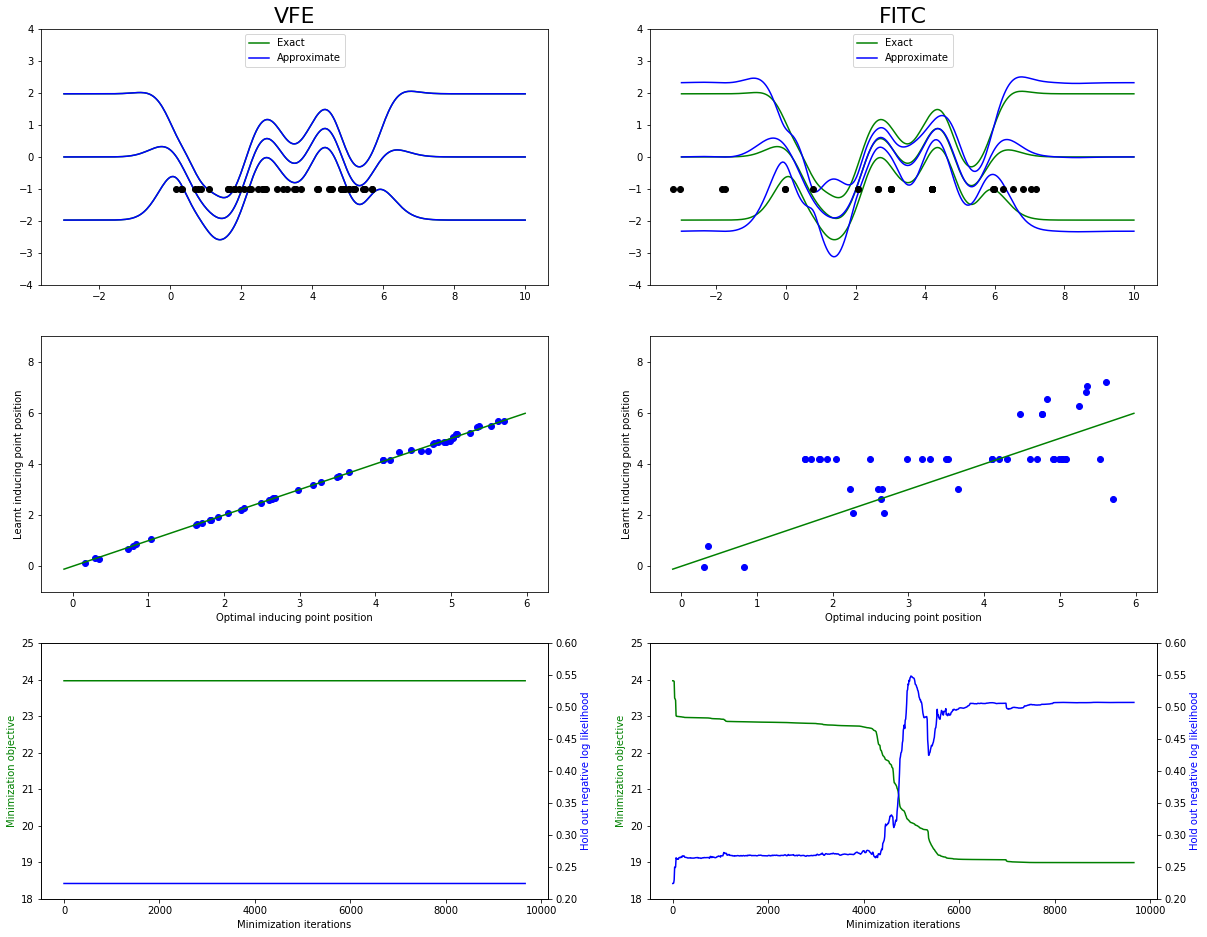

In [6]:
figB, axes = plt.subplots(3, 2, figsize=(20, 16))

# VFE optimization finishes after 10 iterations, so we stretch out the training and test
# log-likelihood traces to make them comparable against FITC:
VFEiters = FITCcb.n_iters
VFElog_likelihoods = stretch(len(VFEiters), VFEcb.log_likelihoods)
VFEhold_out_likelihood = stretch(len(VFEiters), VFEcb.hold_out_likelihood)

axes[0,0].set_title('VFE', loc='center', fontdict = {'fontsize': 22})
plotComparisonFigure(xtrain, VFEmodel, exact_model, axes[0,0], axes[1,0], axes[2,0],
                     VFEiters, VFElog_likelihoods, VFEhold_out_likelihood)

axes[0,1].set_title('FITC', loc='center', fontdict = {'fontsize': 22})
plotComparisonFigure(xtrain, FITCmodel, exact_model, axes[0,1], axes[1,1], axes[2,1],
                     FITCcb.n_iters, FITCcb.log_likelihoods, FITCcb.hold_out_likelihood)

A more detailed discussion of the comparison between these sparse approximations can be found in [Understanding Probabilistic Sparse Gaussian Process Approximations](http://papers.nips.cc/paper/6477-understanding-probabilistic-sparse-gaussian-process-approximations) by Bauer, van der Wilk, and Rasmussen (2017).